# Embeddings in practice

## Choosing an embedding dimension

The embedding dimension is the length of the embedding vector for a given categorical variable. As such, it is a hyperparameter, i.e., we set it manually. But what's the right size?

**The low end:**
In theory, due to the universal approximation theorem, one dimension could be enough (representing each categorical value by a different float). However, in practice it's very hard for a neural network to learn to make use of this information, so we'll want something larger than one.

**The high end:**
Using more dimensions than the number of categorical values is wasteful. Setting the embedding dimension to the number of nuances already allows for them to be fully seperated into orthogonal subspaces, which provides the greatest possible separation. A larger embedding space won't help.

**Reasonable sizes:**
More compact embedding spaces save parameters, and thus ram and compute capacity. However, if the dimensionality of the embeddings becomes too low, we could end up with "collisions" in the embedding space, i.e., some nuances of the categorical variables might map to vectors very close to each other, and downstreams layers will have a hard time separating them.

**In practice:**
In practice we often just set it to the same dimension as the rest of the network or use hyper parameter optimization to find a good value.

In [ ]:
class CategoricalVariable:
  def __init__(self, values):
    self.values = values
    self.index_mapping = {x: i for i,x in enumerate(self.values)}
    self.inv_index_mapping = {i:x for x,i in self.index_mapping.items()}

  def toindex(self, value):
    return self.index_mapping[value]

  def fromindex(self, index):
    return self.inv_index_mapping[index]
  
  def __len__(self):
    return len(self.values)
    
ATOM_TYPES = CategoricalVariable(['H', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl'])

molecule_atoms = ['C', 'C', 'C', 'O', 'N', 'O']
print('Atoms in molecule (names):', molecule_atoms)

encoded_molecule = [ATOM_TYPES.toindex(x) for x in molecule_atoms]
print('Encoded atoms in molecule(indices):', encoded_molecule)

decoded_molecule = [ATOM_TYPES.fromindex(x) for x in encoded_molecule]
print('Decoded atoms in molecule (names):', decoded_molecule)

Atoms in molecule (names): ['C', 'C', 'C', 'O', 'N', 'O']
Encoded atoms in molecule(indices): [1, 1, 1, 3, 2, 3]
Decoded atoms in molecule (names): ['C', 'C', 'C', 'O', 'N', 'O']


In [ ]:
import torch
# create embedding
num_embeddings = len(ATOM_TYPES)
embedding_dim = 4
atom_type_embedding = torch.nn.Embedding(num_embeddings, embedding_dim)

# embed the previously encoded molecule (atoms)
embedded_molecule = atom_type_embedding(torch.tensor(encoded_molecule))

print('Tensor of embedded atoms:')
print(embedded_molecule)

Tensor of embedded atoms:
tensor([[-1.0282, -0.6826,  0.0312, -0.6560],
        [-1.0282, -0.6826,  0.0312, -0.6560],
        [-1.0282, -0.6826,  0.0312, -0.6560],
        [ 0.4156, -0.4048,  0.9909, -0.1961],
        [-0.4378, -0.1256, -0.7233, -0.9696],
        [ 0.4156, -0.4048,  0.9909, -0.1961]], grad_fn=<EmbeddingBackward>)


## Multiple categorical variables
It's common in graph neural networks to use multiple feature vectors (categorical variables) as input. For example, nodes in molecular graphs often have many different categorical features such as atom type and valence (number of electrons that an atom uses in bonding). So how do we deal with multiple features? First of all, since these categorical features are _not_ mutually exclusive, we need to create separate embeddings for each of them:

In [ ]:
import torch

# define categorical variables
atom_types = CategoricalVariable(['C', 'O', 'N', 'H', 'P', 'S', 'F'])
valences = CategoricalVariable(list(range(0, 8)))
categorical_variables = [atom_types, valences]

# create separate embeddings for atom_types and valences
embedding_dim = 4
embeddings = [torch.nn.Embedding(len(variable), embedding_dim) for variable in
              categorical_variables]

# create molecule and encode it
atom_a = ['C', 2]
atom_b = ['O', 1]
atom_c = ['N', 1]
molecule = [atom_a, atom_b, atom_c]
encoded_molecule = [[var.toindex(x) for var, x in 
                     zip(categorical_variables, atom)] for atom in molecule]

print("Encoded molecule:")
for atom in encoded_molecule:
  print(atom)
print()

# convert to tensor and get embeddings
t_encoded_molecule = [torch.tensor(atom) for atom in encoded_molecule]
molecule_embeddings = [[emb(x) for emb, x in zip(embeddings, atom)] for atom in
                        t_encoded_molecule]

print("Molecule embeddings:")
for emb in molecule_embeddings:
  print(emb)


Encoded molecule:
[0, 2]
[1, 1]
[2, 1]

Molecule embeddings:
[tensor([-0.5079,  1.8649,  1.0176, -0.2199], grad_fn=<EmbeddingBackward>), tensor([-0.8118,  0.2734, -1.4632, -0.4368], grad_fn=<EmbeddingBackward>)]
[tensor([ 2.8507, -1.7065,  0.1570, -1.6991], grad_fn=<EmbeddingBackward>), tensor([-0.5896,  0.2466, -0.2816,  0.3149], grad_fn=<EmbeddingBackward>)]
[tensor([ 1.3932, -1.2421,  0.9209, -2.4032], grad_fn=<EmbeddingBackward>), tensor([-0.5896,  0.2466, -0.2816,  0.3149], grad_fn=<EmbeddingBackward>)]


## Combining embeddings

### Concatenation
As you can see we now have one embedding vector per categorical variabe, so a pair of embeddings per atom in this case. So how do we make this pair of vectors into a single vector which we can feed into our neural network? A common approach is to concatenate the embedding vectors, creating one large vector:

In [ ]:
# concatenate individual embeddings
embeddings_concat = [torch.cat(embeddings) for embeddings in
                     molecule_embeddings]

print('Concatenated embeddings:')
for emb in embeddings_concat:
  print(emb)

Concatenated embeddings:
tensor([-0.5079,  1.8649,  1.0176, -0.2199, -0.8118,  0.2734, -1.4632, -0.4368],
       grad_fn=<CatBackward>)
tensor([ 2.8507, -1.7065,  0.1570, -1.6991, -0.5896,  0.2466, -0.2816,  0.3149],
       grad_fn=<CatBackward>)
tensor([ 1.3932, -1.2421,  0.9209, -2.4032, -0.5896,  0.2466, -0.2816,  0.3149],
       grad_fn=<CatBackward>)


Note: We could assign different embedding dimensions to the different categorical variables. If a categorical variable corresponds to a word from a vocabulary of 10000, it would likely need a higher embedding dimension than one which corresponds to a word from a vocabulary of 100.

However, in practice we don't decide on the size of the embedding space purely based on the optimal size for ech categorical variable individually. Instead, we typically want the sizes of layers in a GNN to remain constant -- both in the dense layers within a GNN layer, and across GNN layers. If we want to use residual connections within a GNN layer, we even _have to_ keep the layer sizes constant.

One might therefore approach the decision from the other end: Given a fixed size for each layer in the network (and thus also a fixed embedding dimension), how do we divide this up between multiple categorical variables?

### A better way: Summing up

Fortunately, we don't have to make that decision. Instead of concatenating various embeddings of different sizes, we can use the same size for all embeddings, and sum them up into one vector.

A few remarks on this:

(1) This approach can theoretically lead to the exact same result as a concatenation: Say we have two categorical variables with an embedding dimension of 8. And say that for variable 1, columns 7 and 8 are exactly zero, while for variable 2, columns 1 through 6 are exactly zero. Then, summing up these variables is exactly equivalent to concatenating one embedding of size 6, and another of size 2:

$
\\
var_1 = 
\begin{bmatrix}
    1.1 & -2.2 & -0.4 & 0.2 & 0.9 & -1.5 & 0 & 0
\end{bmatrix}
\\
var_2 =
\begin{bmatrix}
    0 & 0 & 0 & 0 & 0 & 0 & 2.0 & -0.3
\end{bmatrix}
\\
var_1 + var_2 =
\begin{bmatrix}
    1.1 & -2.2 & -0.4 & 0.2 & 0.9 & -1.5 & 2.0 & -0.3
\end{bmatrix}
\\
$

and

$
var_3 = 
\begin{bmatrix}
    1.1 & -2.2 & -0.4 & 0.2 & 0.9 & -1.5
\end{bmatrix}
\\
var_4 =
\begin{bmatrix}
    2.0 & -0.3
\end{bmatrix}
\\
Concat ( var_3, var_4 ) =
\begin{bmatrix}
    1.1 & -2.2 & -0.4 & 0.2 & 0.9 & -1.5 & 2.0 & -0.3
\end{bmatrix}
\\
$


(2) If a concatenation was the best use of the embedding space, the network would (hopefully) learn a solution very close to this. It could, in theory, also find that a different size allocation is better, and go for instance for a 5:3 or 4:4 split.

(3) In practice, things won't be as neatly ordered, and almost certainly the network will end up sharing embedding dimensions between multiple variables. This way, correlations between these variables can end up being implicitly encoded in the embeddings themselves, which can be good or bad, depending on your point of view. Overall though, it will generally make more efficient use of the shared embedding space than a concatenation would. In practice, this typically leads to higher performance at a given embedding and layer size.

Let's do this in code:

In [ ]:
# sum individual embeddings
embeddings_summed = [torch.sum(torch.stack(embeddings),0) for embeddings in
                     molecule_embeddings]

print('Summed embeddings:')
for emb in embeddings_summed:
  print(emb)

Summed embeddings:
tensor([-1.3196,  2.1383, -0.4456, -0.6567], grad_fn=<SumBackward1>)
tensor([ 2.2611, -1.4599, -0.1247, -1.3842], grad_fn=<SumBackward1>)
tensor([ 0.8037, -0.9954,  0.6392, -2.0883], grad_fn=<SumBackward1>)


## Datatypes for categorical and continuous variables

We previously created a datatype "CategoricalFeature". For coding convenience we shall now extend this class with the functions $__repr__()$, $__eq__()$ and $__hash__()$. $__repr__()$ makes the printouts of this class nicer looking, while $__eq__()$ and $__hash__()$ allows these to be correctly used as dictionary keys. 

Moreover, we shall create an analogous class for continuous features:

In [ ]:
class CategoricalFeature:

  def __init__(self, name, values):
    self.name = name
    self.values = tuple(values)
    self.value_to_idx_mapping = {v: i for i, v in enumerate(values)}
    self.inv_value_to_idx_mapping = {i: v for v, i
                                     in self.value_to_idx_mapping.items()}
  
  def value_to_idx(self, value):
    return self.value_to_idx_mapping[value]
  
  def idx_to_value(self, idx):
    return self.inv_value_to_idx_mapping[idx]
  
  def __len__(self):
    return len(self.values)
  
  def __repr__(self):
    return f'<CategoricalFeature: {self.name}>'

  def __eq__(self, other):
    return self.name == other.name and self.values == other.values

  def __hash__(self):
    return hash((self.name, self.values))

class ContinuousFeature:
  def __init__(self, name):
    self.name = name

  def __repr__(self):
    return f'<ContinuousFeature: {self.name}>'

  def __eq__(self, other):
    return self.name == other.name

  def __hash__(self):
    return hash(self.name)

Finally, let's revisit the graphic from the previous notebook. As you can see, it already included the summation of embeddings, as opposed to concatenation. By now, all parts of this graphic should make sense to you, and you should be able to implement the pipeline from raw data to feature vectors.

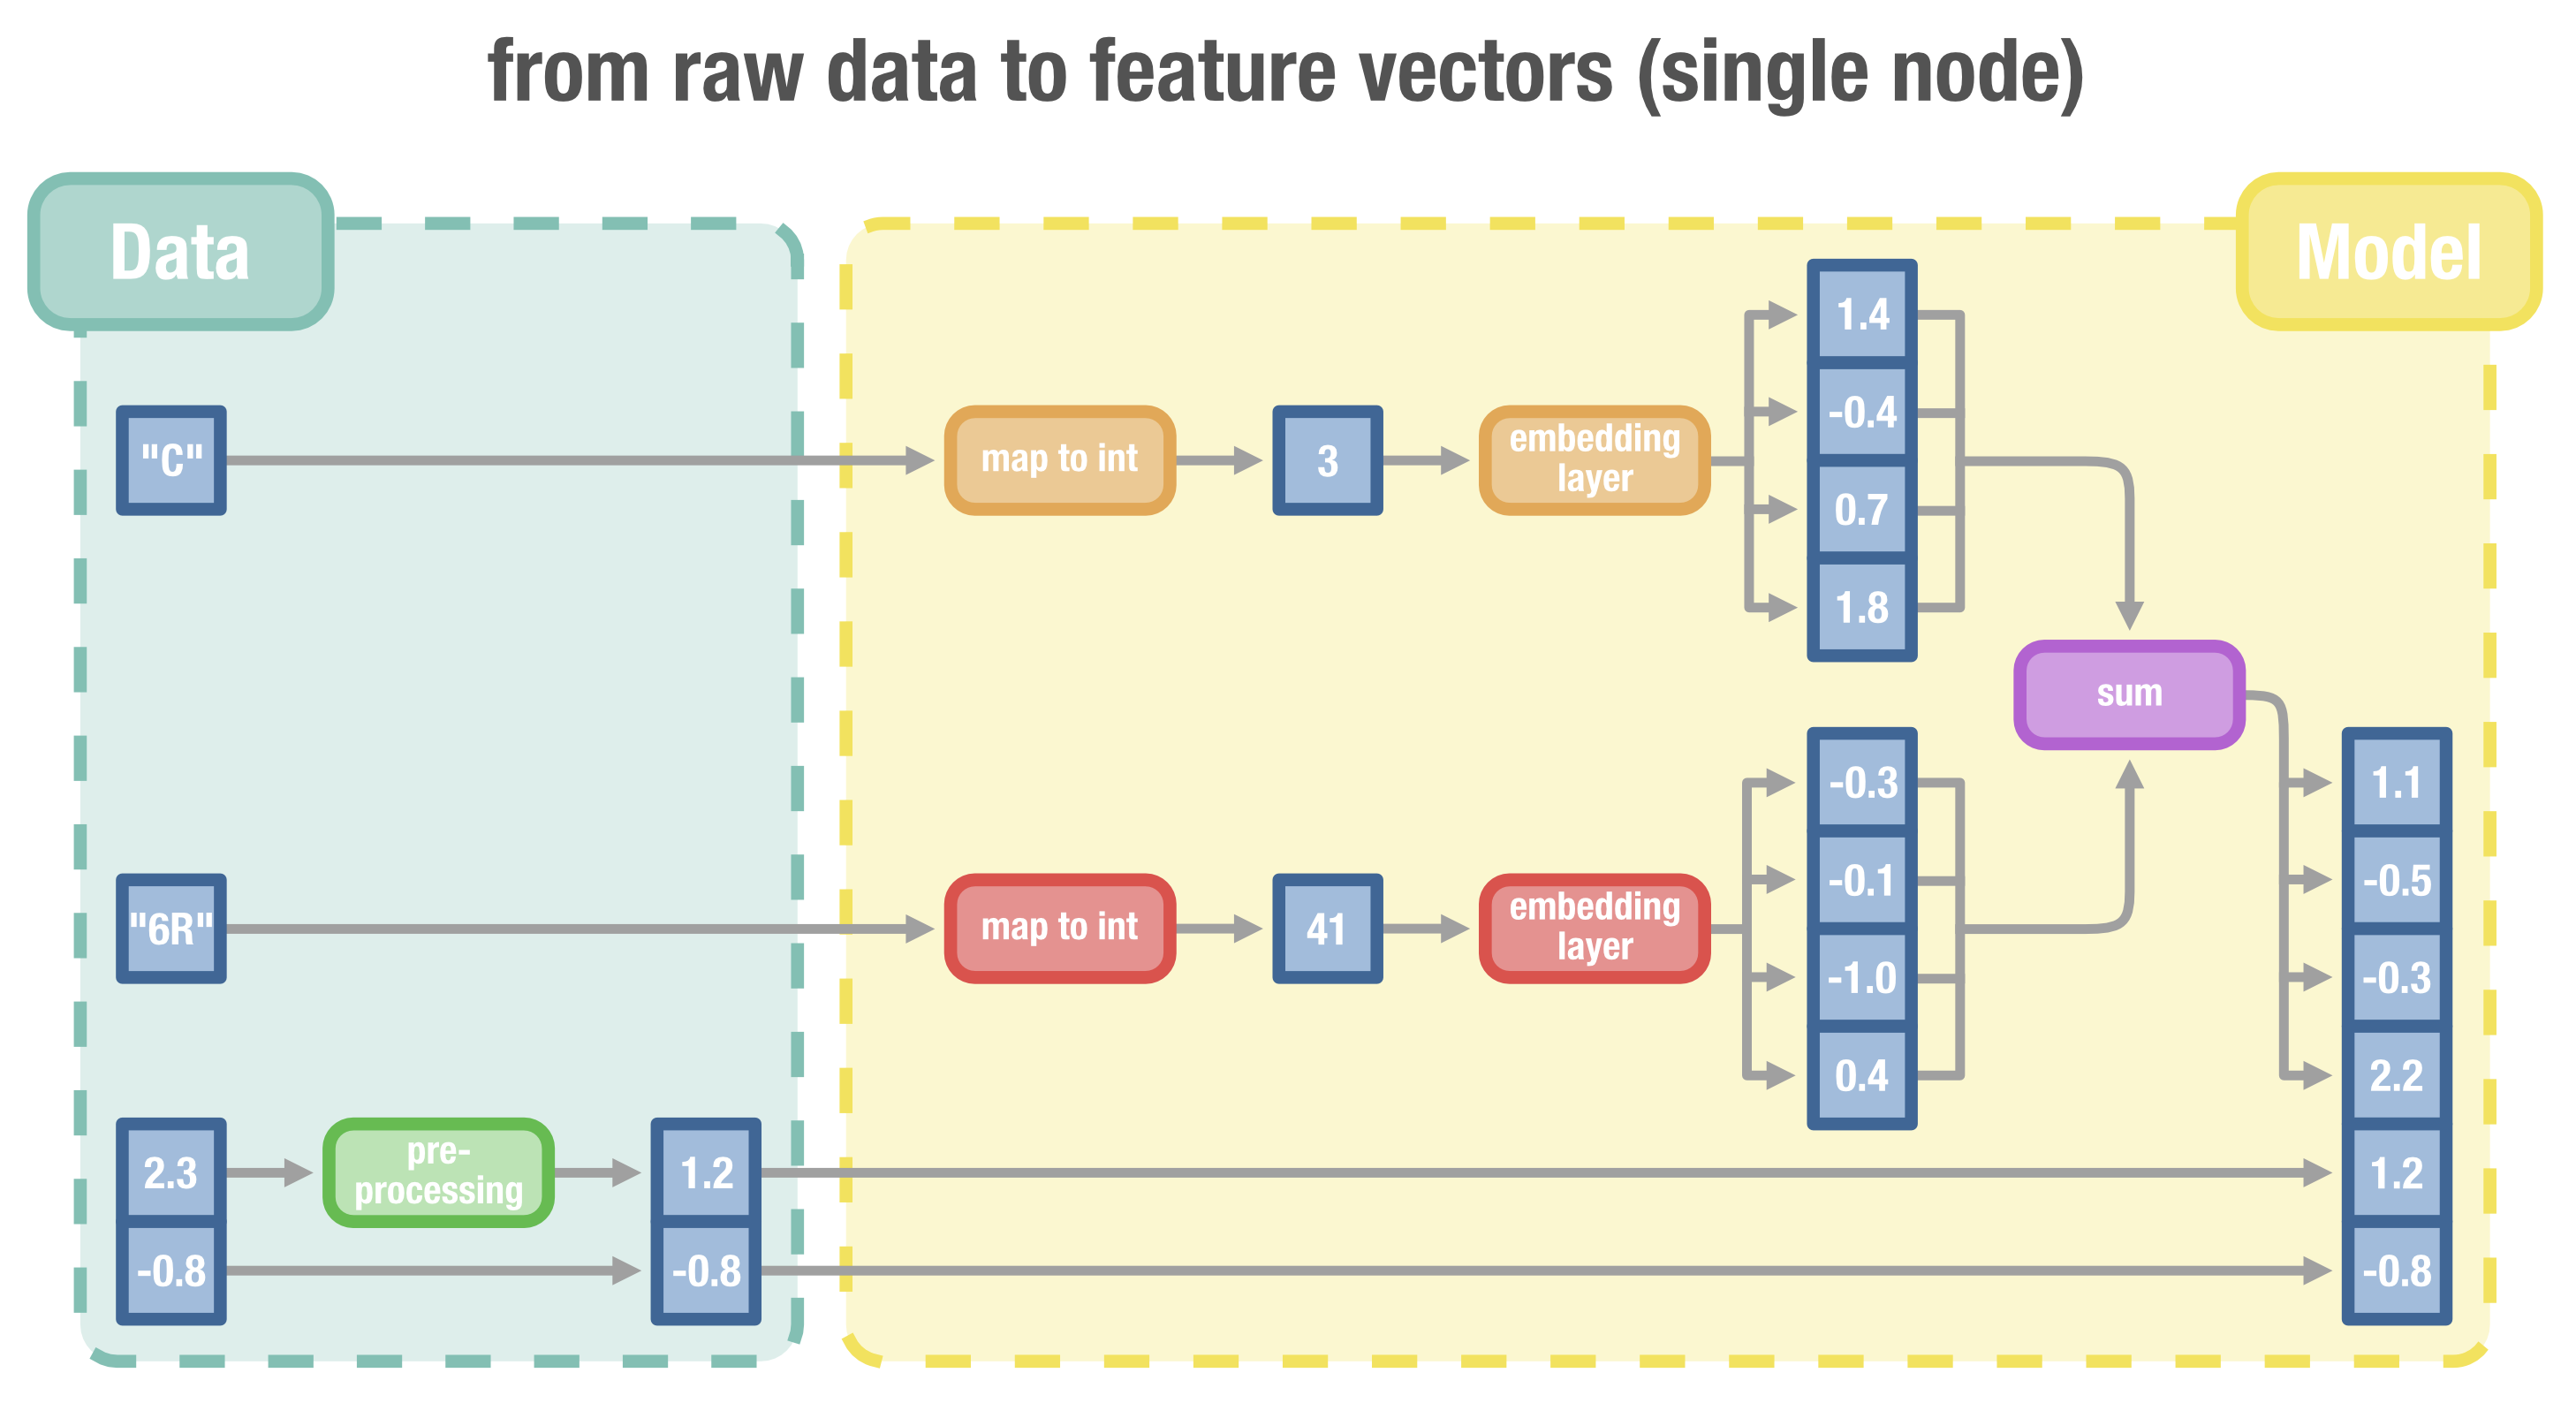

# Tasks

## Questions

Can you answer the following questions?

(1) How do we represent continuous features for GNNs?

(2) How do we represent categorical features for GNNs?

(3) What is an embedding layer, what are its inputs and outputs?

(4) How do we combine features from multiple continuous and categorical variables?

If you struggle to answer these, please revisit the corresponding sections in this and the previous notebook. ***If after this you still struggle, please ask a tutor.***

In [ ]:
#@title Default title text
### your answers here ###

# What is embedding layer and what is its inputs and outputs? 
# Note that with categorical variables the embedding layer is part of the model and not of the dataset.
# the correct row in the embedding layer, and the embedding layer itself ("emb" above) is the first layer in the network.


# Continuous features are numerical by nature, and are typically represented as real numbers (e.g., float). Categorical features on the other hand are variables from a finite set of discrete values, such as the type of atom, a person's native language, or the publishing journal of a paper




## Coding

Implement the entire pipeline from raw data to feature vectors in a toy example. The following code block should be self-contained, i.e., it should not reference previously defined variables (copy & pasting is allowed). Feel free to use your solution from notebook 01A as a starting point.

In [4]:
### your code here ###
class CategoricalVariable:
  def __init__(self, values):
    self.values = values
    self.index_mapping = {x: i for i,x in enumerate(self.values)}
    self.inv_index_mapping = {i:x for x,i in self.index_mapping.items()}

  def toindex(self, value):
    return self.index_mapping[value]

  def fromindex(self, index):
    return self.inv_index_mapping[index]
  
  def __len__(self):
    return len(self.values)
    
ATOM_TYPES = CategoricalVariable(['H', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl'])

molecule_atoms = ['C', 'C', 'C', 'O', 'N', 'O']
print('Atoms in molecule (names):', molecule_atoms)

encoded_molecule = [ATOM_TYPES.toindex(x) for x in molecule_atoms]
print('Encoded atoms in molecule(indices):', encoded_molecule)

decoded_molecule = [ATOM_TYPES.fromindex(x) for x in encoded_molecule]
print('Decoded atoms in molecule (names):', decoded_molecule)



import torch

# define categorical variables
atom_types = CategoricalVariable(['C', 'O', 'N', 'H', 'P', 'S', 'F'])
valences = CategoricalVariable(list(range(0, 8)))
categorical_variables = [atom_types, valences]

# create separate embeddings for atom_types and valences
embedding_dim = 4
embeddings = [torch.nn.Embedding(len(variable), embedding_dim) for variable in
              categorical_variables]

# create molecule and encode it
atom_a = ['C', 2]
atom_b = ['O', 1]
atom_c = ['N', 1]
molecule = [atom_a, atom_b, atom_c]
encoded_molecule = [[var.toindex(x) for var, x in 
                     zip(categorical_variables, atom)] for atom in molecule]

for atom in molecule:
  print(atom)
  

print("Encoded molecule:")
for atom in encoded_molecule:
  print(atom)
print()

# convert to tensor and get embeddings
t_encoded_molecule = [torch.tensor(atom) for atom in encoded_molecule]
molecule_embeddings = [[emb(x) for emb, x in zip(embeddings, atom)] for atom in
                        t_encoded_molecule]

print("Molecule embeddings:")
for emb in molecule_embeddings:
  print(emb)


# concatenate individual embeddings
embeddings_concat = [torch.cat(embeddings) for embeddings in
                     molecule_embeddings]

print('Concatenated embeddings:')
for emb in embeddings_concat:
  print(emb)

Atoms in molecule (names): ['C', 'C', 'C', 'O', 'N', 'O']
Encoded atoms in molecule(indices): [1, 1, 1, 3, 2, 3]
Decoded atoms in molecule (names): ['C', 'C', 'C', 'O', 'N', 'O']
['C', 2]
['O', 1]
['N', 1]
Encoded molecule:
[0, 2]
[1, 1]
[2, 1]

Molecule embeddings:
[tensor([ 0.2287, -1.6342, -0.0464,  1.0213], grad_fn=<EmbeddingBackward>), tensor([-0.0128, -0.3933,  0.2725,  0.5956], grad_fn=<EmbeddingBackward>)]
[tensor([ 0.1797, -0.7388, -0.4018,  0.5159], grad_fn=<EmbeddingBackward>), tensor([0.3372, 2.7910, 0.6279, 0.0452], grad_fn=<EmbeddingBackward>)]
[tensor([ 0.6312, -0.3202, -0.2682,  0.9070], grad_fn=<EmbeddingBackward>), tensor([0.3372, 2.7910, 0.6279, 0.0452], grad_fn=<EmbeddingBackward>)]
Concatenated embeddings:
tensor([ 0.2287, -1.6342, -0.0464,  1.0213, -0.0128, -0.3933,  0.2725,  0.5956],
       grad_fn=<CatBackward>)
tensor([ 0.1797, -0.7388, -0.4018,  0.5159,  0.3372,  2.7910,  0.6279,  0.0452],
       grad_fn=<CatBackward>)
tensor([ 0.6312, -0.3202, -0.2682,  0.907